In [10]:
import yfinance as yf  # Import the yfinance library to fetch financial data
import pandas as pd  # Import pandas for data manipulation and analysis
from sklearn.model_selection import train_test_split, GridSearchCV  # Import functions for splitting data and hyperparameter tuning
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor for regression tasks
from sklearn.metrics import mean_squared_error  # Import mean_squared_error to evaluate model performance
import numpy as np  # Import numpy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting graphs
from datetime import datetime, timedelta  # Import datetime for handling dates

In [13]:

data = yf.download('BTC-USD', start='2020-01-01', end=datetime.now().strftime('%Y-%m-%d'))  # Download Bitcoin price data from Yahoo Finance

data['Return'] = data['Close'].pct_change()  # Calculate daily return as the percentage change of the closing price
data['Volatility'] = data['Return'].rolling(window=7).std()  # Calculate 7-day rolling volatility based on returns
data['MA_5'] = data['Close'].rolling(window=5).mean()  # Calculate 5-day moving average of closing prices
data['MA_10'] = data['Close'].rolling(window=10).mean()  # Calculate 10-day moving average of closing prices
data['MA_30'] = data['Close'].rolling(window=30).mean()  # Calculate 30-day moving average of closing prices
data.dropna(inplace=True)  # Remove rows with NaN values from the dataset


[*********************100%***********************]  1 of 1 completed


In [14]:

X = data[['Return', 'Volatility', 'MA_5', 'MA_10', 'MA_30']]  # Select features for the model
y = data['Close'].shift(-1)  # Shift closing prices to use the next day's price as the target variable

X_train, X_test, y_train, y_test = train_test_split(X[:-1], y[:-1], test_size=0.2, random_state=42)  # Split data into training and testing sets

param_grid = {
    'n_estimators': [100, 200, 300],  # Specify the number of trees in the forest for hyperparameter tuning
    'max_depth': [None, 10, 20, 30],  # Specify the maximum depth of the trees
}


In [17]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)  # Initialize GridSearchCV for hyperparameter optimization
grid_search.fit(X_train, y_train)  # Fit the model to the training data

best_model = grid_search.best_estimator_  # Get the best model from the grid search

predictions = best_model.predict(X_test)  # Predict the closing prices on the test set

mse = mean_squared_error(y_test, predictions)  # Calculate the mean squared error of the predictions
print(f'Test MSE: {mse}')  # Print the mean squared error

last_data = X.iloc[-1].values.reshape(1, -1)  # Get the last day's data and reshape it for prediction
future_predictions = []  # Initialize a list to store future predictions

for day in range(7):  # Loop for the next 7 days
    next_prediction = best_model.predict(last_data)  # Predict the next day's closing price
    future_predictions.append(next_prediction[0])  # Append the prediction to the list
    
    last_return = (next_prediction[0] - last_data[0][1]) / last_data[0][1]  # Calculate the return based on the predicted price
    last_volatility = np.std(np.append(data['Return'].values[-7:], last_return))  # Calculate the volatility using the last 7 days' returns
    last_data = np.array([[last_return, last_volatility, last_data[0][2], last_data[0][3], last_data[0][4]]]).reshape(1, -1)  # Update the last data for the next prediction

last_week_dates = pd.date_range(end=datetime.now(), periods=7).to_list()  # Create a date range for the last week
last_week_data = yf.download('BTC-USD', start=last_week_dates[0], end=datetime.now().strftime('%Y-%m-%d'))  # Download Bitcoin data for the last week

print("Actual closing prices for the last week:")  # Print statement for actual closing prices
print(last_week_data['Close'])  # Print the actual closing prices

print("Bitcoin predictions for next week:")  # Print statement for future predictions
for i, prediction in enumerate(future_predictions):  # Loop through future predictions
    prediction_date = datetime.now() + timedelta(days=i + 1)  # Calculate the date for the prediction
    print(f"Prediction for the day ({prediction_date.strftime('%Y-%m-%d')}): {prediction} USD")  # Print the prediction for each day


c:\Users\berat\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\berat\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\berat\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\berat\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\berat\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\berat\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Test MSE: 2011735.9178063357
Actual closing prices for the last week:
Date
2024-10-16    67612.718750
2024-10-17    67399.835938
2024-10-18    68418.789062
2024-10-19    68362.734375
2024-10-20    69001.703125
2024-10-21    67689.468750
Name: Close, dtype: float64
Bitcoin predictions for next week:
Prediction for the day (2024-10-23): 67449.7238671875 USD
Prediction for the day (2024-10-24): 69387.54044270833 USD
Prediction for the day (2024-10-25): 67277.01399739583 USD
Prediction for the day (2024-10-26): 69387.54044270833 USD
Prediction for the day (2024-10-27): 68013.37838541667 USD
Prediction for the day (2024-10-28): 69387.54044270833 USD
Prediction for the day (2024-10-29): 67277.01399739583 USD


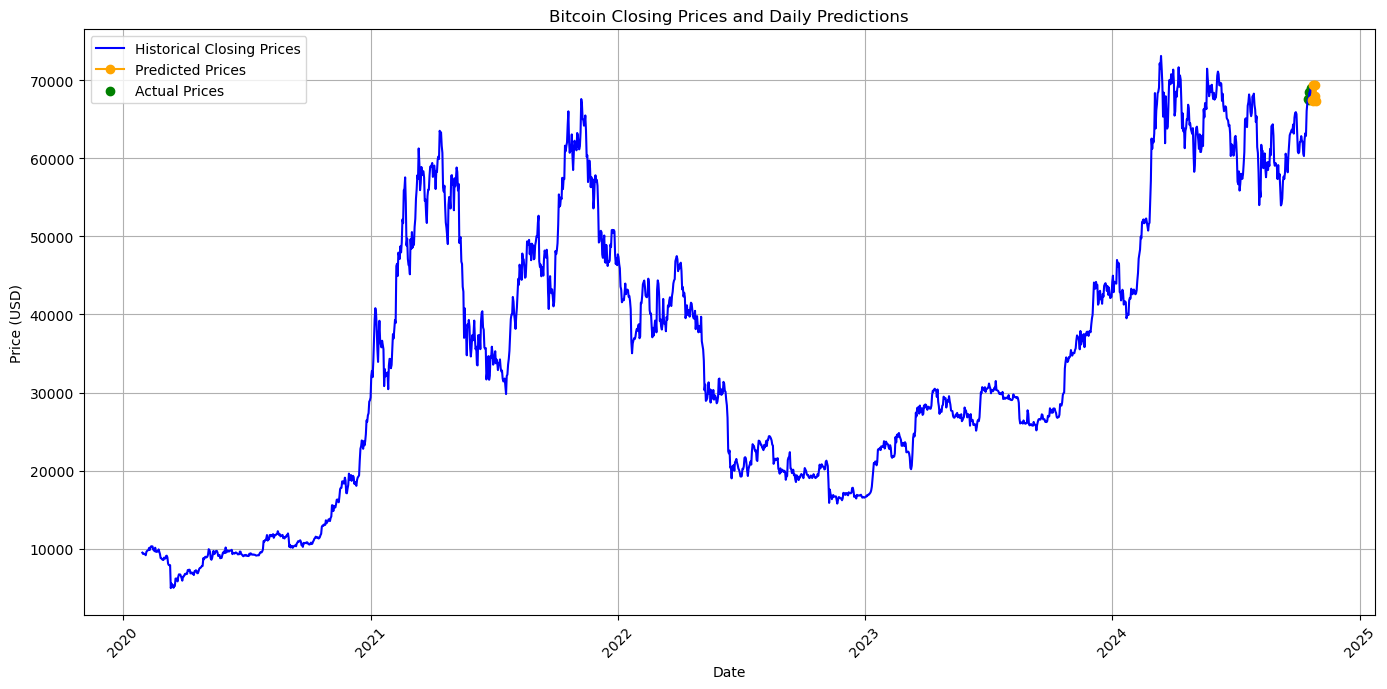

In [18]:
plt.figure(figsize=(14, 7))  # Create a figure for the plot
plt.plot(data.index, data['Close'], label='Historical Closing Prices', color='blue')  # Plot historical closing prices
future_dates = [data.index[-1] + timedelta(days=i) for i in range(1, 8)]  # Generate future dates for the predictions
plt.plot(future_dates, future_predictions, label='Predicted Prices', color='orange', marker='o')  # Plot predicted prices

plt.scatter(last_week_data.index, last_week_data['Close'], color='green', label='Actual Prices')  # Scatter plot for actual prices

plt.title('Bitcoin Closing Prices and Daily Predictions')  # Set the title of the plot
plt.xlabel('Date')  # Label the x-axis
plt.ylabel('Price (USD)')  # Label the y-axis
plt.legend()  # Display the legend
plt.grid()  # Add a grid to the plot
plt.xticks(rotation=45)  # Rotate x-axis ticks for better readability
plt.tight_layout()  # Adjust the layout of the plot

plt.show()  # Display the plot
